# Untangling fMRI data to classify Alzheimer's codebook

> Add blockquote




NOTE: some of the code, especially for formatting, was taken from here https://www.kaggle.com/code/faressayah/practical-guide-to-6-classification-algorithms

In [ ]:
pip install --upgrade ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 23.2.1
    Uninstalling pyzmq-23.2.1:
      Successfully uninstalled pyzmq-23.2.1
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.4 which is incompatible.
notebook 6.5.5 requires pyzmq<25,>=17, but you have pyzmq 25.1.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Importing the dataset

In [66]:
data = pd.read_csv('/content/drive/MyDrive/oasis_longitudinal.csv')
data = pd.DataFrame(data)
#turning the columns into integers for ease
data['M/F'] = data['M/F'].replace(['M', 'F'], [0,1])
data['Group'] = data['Group'].replace(['Converted','Nondemented', 'Demented'], [0,1,2])
data['Hand'] = data['Hand'].replace(['R','L'], [0,1])
data['Subject ID'] = data.groupby('Subject ID').ngroup()
data['MRI ID'] = data.groupby('MRI ID').ngroup()
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,1,1,0,0,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,0,1,1,2,457,0,0,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,2,2,1,0,0,0,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,1,3,2,2,560,0,0,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,1,4,2,3,1895,0,0,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [32]:
data.describe()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.0,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,73.343164,186.000000,1.292225,1.882038,595.104558,0.571046,0.0,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,43.625116,107.820066,0.637425,0.922843,635.485118,0.495592,0.0,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,36.000000,93.000000,1.000000,1.000000,0.000000,0.000000,0.0,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,71.000000,186.000000,1.000000,2.000000,552.000000,1.000000,0.0,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,111.000000,279.000000,2.000000,2.000000,873.000000,1.000000,0.0,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,149.000000,372.000000,2.000000,5.000000,2639.000000,1.000000,0.0,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


## Some visualizations

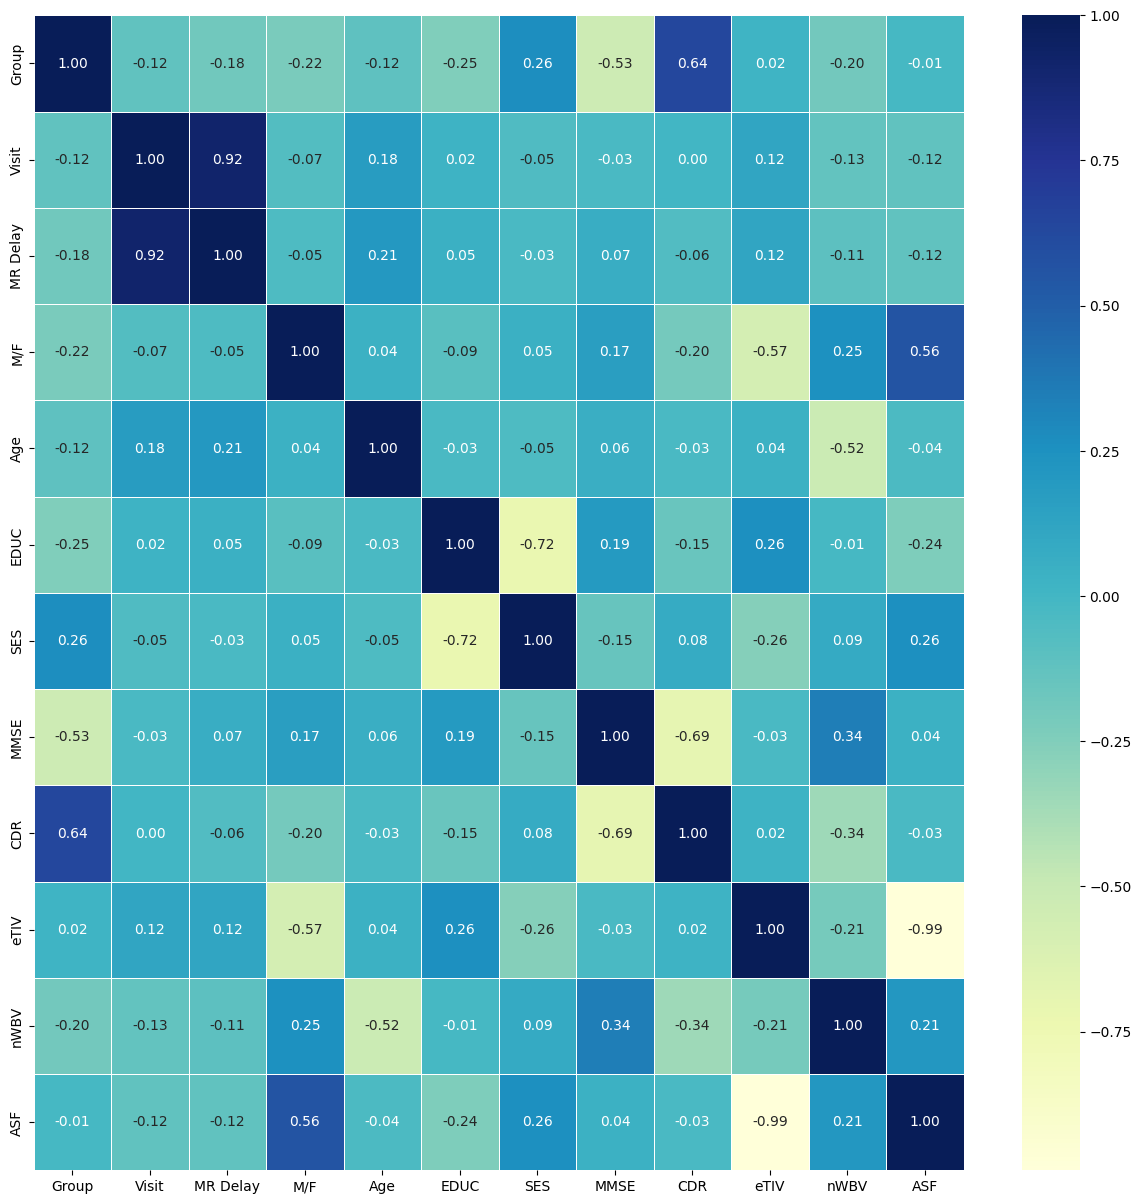

In [37]:
data_relevant = data[["Group", "Visit", "MR Delay", "M/F", "Age", "EDUC", "SES", "MMSE", "CDR", "eTIV", "nWBV","ASF"]]
corr_matrix = data_relevant.corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()


In [44]:
data['CDR'].value_counts()

CDR
0.0    206
0.5    123
1.0     41
2.0      3
Name: count, dtype: int64

In [45]:
data['Group'].value_counts()

Group
1    190
2    146
0     37
Name: count, dtype: int64

Text(0.5, 28.999999999999993, 'Estimated Total Intracranial Volume')

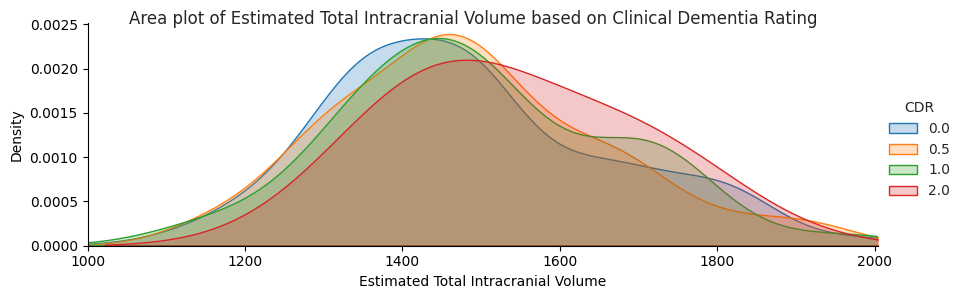

In [48]:
facet= sns.FacetGrid(data,hue="CDR", aspect=3)
sns.set_style("darkgrid")
facet.map(sns.kdeplot,'eTIV', fill= True)
facet.set(xlim=(1000, data['eTIV'].max()))
facet.fig.suptitle(f'Area plot of Estimated Total Intracranial Volume based on Clinical Dementia Rating')
facet.add_legend()
plt.xlabel("Estimated Total Intracranial Volume")

Text(0.5, 28.999999999999993, 'Estimated Total Intracranial Volume')

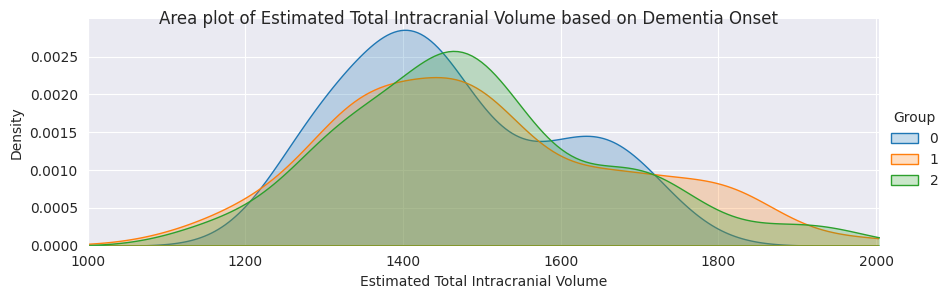

In [90]:
facet= sns.FacetGrid(data,hue="Group", aspect=3)
sns.set_style("darkgrid")
facet.map(sns.kdeplot,'eTIV', fill= True)
facet.set(xlim=(1000, data['eTIV'].max()))
facet.fig.suptitle(f'Area plot of Estimated Total Intracranial Volume based on Dementia Onset')
facet.add_legend()
plt.xlabel("Estimated Total Intracranial Volume")

Text(0.5, 28.999999999999993, 'Normalized Whole Brain Volume')

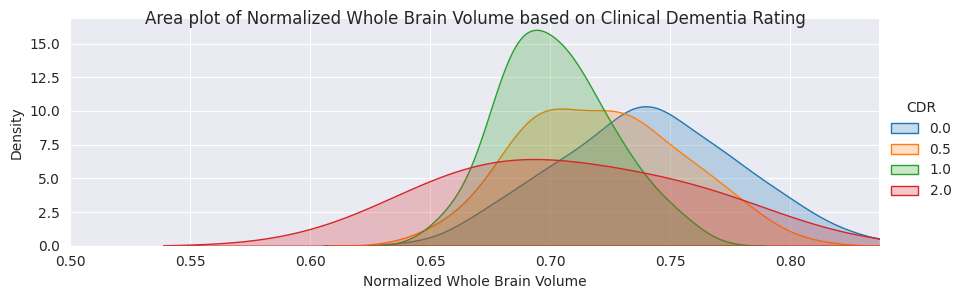

In [49]:
facet= sns.FacetGrid(data,hue="CDR", aspect=3)
sns.set_style("darkgrid")
facet.map(sns.kdeplot,'nWBV', fill= True)
facet.set(xlim=(0.5, data['nWBV'].max()))
facet.fig.suptitle(f'Area plot of Normalized Whole Brain Volume based on Clinical Dementia Rating')
facet.add_legend()
plt.xlabel("Normalized Whole Brain Volume")

Text(0.5, 28.999999999999993, 'Normalized Whole Brain Volume')

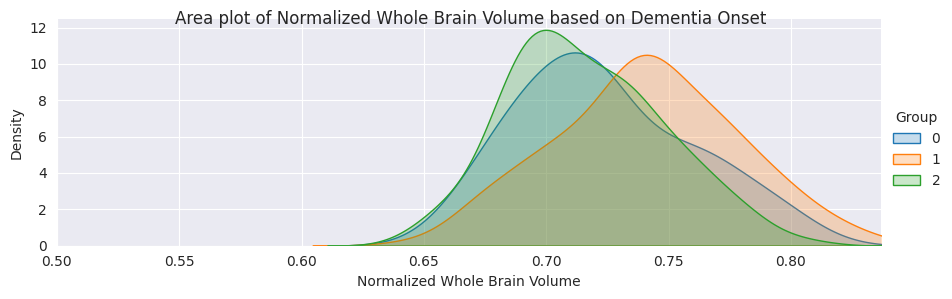

In [91]:
facet= sns.FacetGrid(data,hue="Group", aspect=3)
sns.set_style("darkgrid")
facet.map(sns.kdeplot,'nWBV', fill= True)
facet.set(xlim=(0.5, data['nWBV'].max()))
facet.fig.suptitle(f'Area plot of Normalized Whole Brain Volume based on Dementia Onset')
facet.add_legend()
plt.xlabel("Normalized Whole Brain Volume")

Text(0.5, 28.999999999999993, 'Minimal Mental State Examination')

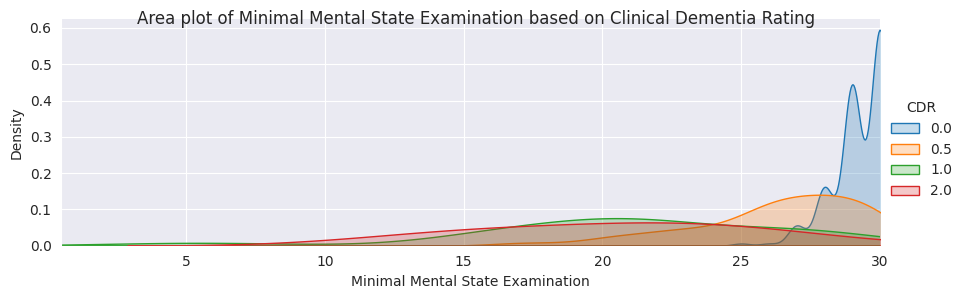

In [50]:
facet= sns.FacetGrid(data,hue="CDR", aspect=3)
facet.map(sns.kdeplot,'MMSE', fill= True)
facet.set(xlim=(0.5, data['MMSE'].max()))
facet.fig.suptitle(f'Area plot of Minimal Mental State Examination based on Clinical Dementia Rating')
facet.add_legend()
plt.xlabel("Minimal Mental State Examination")

Text(0.5, 28.999999999999993, 'Atlas Scaling Factor')

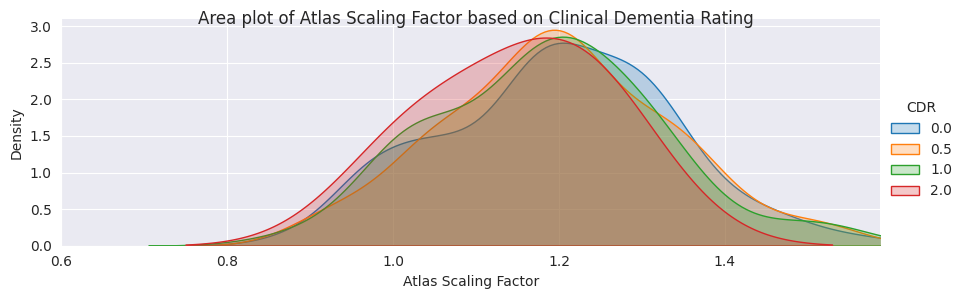

In [51]:
facet= sns.FacetGrid(data,hue="CDR", aspect=3)
sns.set_style("darkgrid")
facet.map(sns.kdeplot,'ASF', fill= True)
facet.set(xlim=(0.6, data['ASF'].max()))
facet.fig.suptitle(f'Area plot of Atlas Scaling Factor based on Clinical Dementia Rating')
facet.add_legend()
plt.xlabel("Atlas Scaling Factor")

Text(0.5, 28.999999999999993, 'Age')

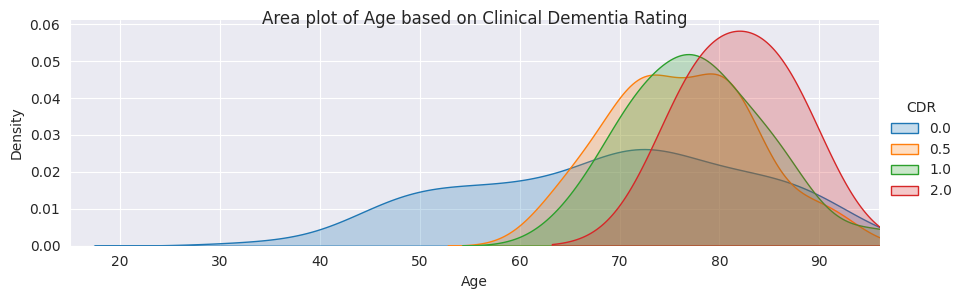

In [ ]:
facet= sns.FacetGrid(data,hue="CDR", aspect=3)
sns.set_style("darkgrid")
facet.map(sns.kdeplot,'Age', fill= True)
facet.set(xlim=(0, data['Age'].max()))
facet.fig.suptitle(f'Area plot of Age based on Clinical Dementia Rating')
facet.add_legend()
plt.xlim(15, 96)
plt.xlabel("Age")

Text(0.5, 28.999999999999993, 'Education on a scale of 1 to 5 categorized by education years')

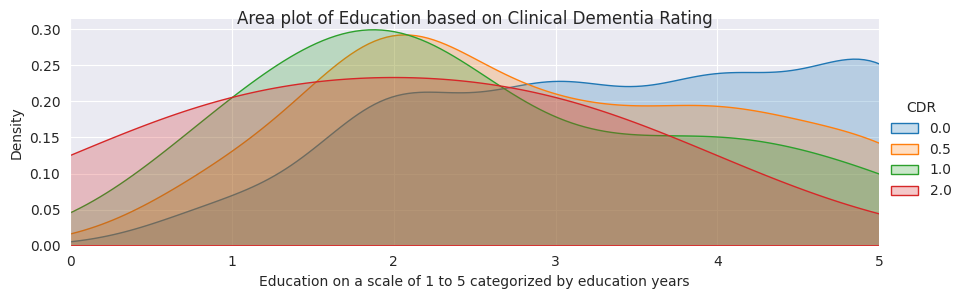

In [ ]:
facet= sns.FacetGrid(data,hue="CDR", aspect=3)
sns.set_style("darkgrid")
facet.map(sns.kdeplot,'Educ', fill= True)
facet.set(xlim=(0, data['Educ'].max()))
facet.fig.suptitle(f'Area plot of Education based on Clinical Dementia Rating')
facet.add_legend()
plt.xlabel("Education on a scale of 1 to 5 categorized by education years")

Text(0.5, 28.999999999999993, 'Socioeconomic status on a scale of 1-5 based on Hollingshead Index of Social Position')

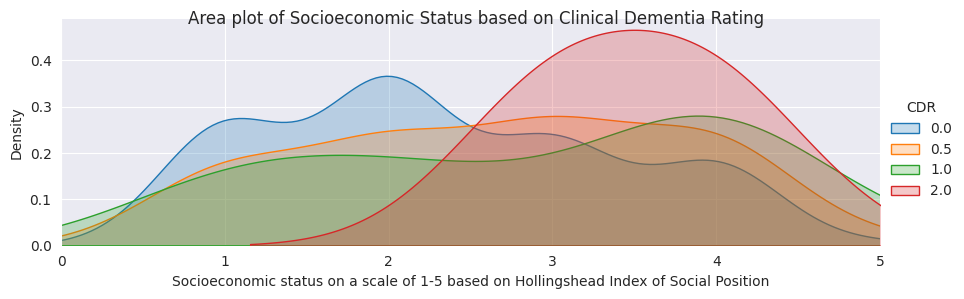

In [ ]:
facet= sns.FacetGrid(data,hue="CDR", aspect=3)
sns.set_style("darkgrid")
facet.map(sns.kdeplot,'SES', fill= True)
facet.set(xlim=(0, data['SES'].max()))
facet.fig.suptitle(f'Area plot of Socioeconomic Status based on Clinical Dementia Rating')
facet.add_legend()
plt.xlabel("Socioeconomic status on a scale of 1-5 based on Hollingshead Index of Social Position")

In [73]:
data.isna().sum()

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [72]:
#Using the most frequent value to impute the SES missing values
from sklearn.impute  import SimpleImputer
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])
data = data.dropna()
data.describe()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.0,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,72.962264,185.075472,1.288410,1.878706,593.876011,0.568733,0.0,77.018868,14.611860,2.439353,27.342318,0.287062,1489.876011,0.729526,1.193776
std,43.431632,107.369278,0.637012,0.923480,636.636500,0.495922,0.0,7.660864,2.877737,1.111835,3.683244,0.371912,174.990473,0.037229,0.136533
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,35.500000,92.500000,1.000000,1.000000,0.000000,0.000000,0.0,71.000000,12.000000,2.000000,27.000000,0.000000,1358.500000,0.700000,1.098500
50%,71.000000,185.000000,1.000000,2.000000,552.000000,1.000000,0.0,77.000000,15.000000,2.000000,29.000000,0.000000,1471.000000,0.729000,1.193000
75%,110.000000,277.500000,2.000000,2.000000,869.500000,1.000000,0.0,82.000000,16.000000,3.000000,30.000000,0.500000,1598.000000,0.756000,1.292000
max,149.000000,372.000000,2.000000,5.000000,2639.000000,1.000000,0.0,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [77]:
#Splitting data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X = data.drop(["Group"],axis=1)
y = data["Group"].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.2,
                                                    random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [78]:
#Function for printing metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Training Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Testing Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [79]:
#Logistic regression - choosing parameters to support multinomial analysis
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_model.fit(X_train_scaled, y_train)
#saving the scores to compare them later
#specifically, using weighted averages to best estimate the metrics
lr_predictions1 = lr_model.predict(X_train_scaled)
lr_accuracy1 = accuracy_score(y_train, lr_predictions1)
lr_precision1 = precision_score(y_train, lr_predictions1, average = 'weighted')
lr_recall1 = recall_score(y_train, lr_predictions1, average = 'weighted')
lr_f1score1 = f1_score(y_train, lr_predictions1, average = 'weighted')
lr_predictions2 = lr_model.predict(X_test_scaled)
lr_accuracy2 = accuracy_score(y_test, lr_predictions2)
lr_precision2 = precision_score(y_test, lr_predictions2, average = 'weighted')
lr_recall2 = recall_score(y_test, lr_predictions2, average = 'weighted')
lr_f1score2 = f1_score(y_test, lr_predictions2, average = 'weighted')
lr_accuracy2 = accuracy_score(y_test, lr_predictions2)
print_score(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, train=True)
print_score(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, train=False)

Training Result:
Accuracy Score: 94.59%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1           2  accuracy   macro avg  \
precision   1.000000    0.940120    0.949153  0.945946    0.963091   
recall      0.423077    0.993671    1.000000  0.945946    0.805583   
f1-score    0.594595    0.966154    0.973913  0.945946    0.844887   
support    26.000000  158.000000  112.000000  0.945946  296.000000   

           weighted avg  
precision      0.948797  
recall         0.945946  
f1-score       0.936453  
support      296.000000  
_______________________________________________
Confusion Matrix: 
 [[ 11  10   5]
 [  0 157   1]
 [  0   0 112]]

Testing Result:
Accuracy Score: 85.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy  macro avg  weighted avg
precision   0.666667   0.794872   0.939394  0.853333   0.800311      0.837731
recall      0.181818   0.96

In [81]:
!pip install tune_sklearn
import random
from sklearn.ensemble import RandomForestClassifier
from tune_sklearn import TuneSearchCV

rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_scaled, y_train)
rfc_predictions1 = rfc_model.predict(X_train_scaled)
#saving the scores to compare them later
#specifically, using weighted averages to best estimate the metrics
rfc_accuracy1 = accuracy_score(y_train, rfc_predictions1)
rfc_precision1 = precision_score(y_train, rfc_predictions1, average = 'weighted')
rfc_recall1 = recall_score(y_train, rfc_predictions1, average = 'weighted')
rfc_f1score1 = f1_score(y_train, rfc_predictions1, average = 'weighted')
rfc_predictions2 = rfc_model.predict(X_test_scaled)
rfc_accuracy2 = accuracy_score(y_test, rfc_predictions2)
rfc_precision2 = precision_score(y_test, rfc_predictions2, average = 'weighted')
rfc_recall2 = recall_score(y_test, rfc_predictions2, average = 'weighted')
rfc_f1score2 = f1_score(y_test, rfc_predictions2, average = 'weighted')
print_score(rfc_model, X_train_scaled, y_train, X_test_scaled, y_test, train=True)
print_score(rfc_model, X_train_scaled, y_train, X_test_scaled, y_test, train=False)

param_distributions = {
    "n_estimators": list(random.randint(20, 80)),
    "max_depth": list(random.randint(2, 10))
}
tune_search = TuneSearchCV(rfc_model, param_distributions, n_trials=3)
tune_search.fit(X_train_scaled, y_train)

pred = tune_search.predict(X_test_scaled)
accuracy = np.count_nonzero(np.array(pred) == np.array(y_test)) / len(pred)
print(accuracy)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.1 MB/s eta 0:00:00
Training Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0      1      2  accuracy  macro avg  weighted avg
precision   1.0    1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0    1.0       1.0        1.0           1.0
support    26.0  158.0  112.0       1.0      296.0         296.0
_______________________________________________
Confusion Matrix: 
 [[ 26   0   0]
 [  0 158   0]
 [  0   0 112]]

Testing Result:
Accuracy Score: 85.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy  macro avg  weighted avg
precision   1.000

TypeError: 'int' object is not iterable

In [88]:
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_model.fit(X_train_scaled, y_train)
dtc_predictions1 = dtc_model.predict(X_train_scaled)
#saving the scores to compare them later
#specifically, using weighted averages to best estimate the metrics
dtc_accuracy1 = accuracy_score(y_train, dtc_predictions1)
dtc_precision1 = precision_score(y_train, dtc_predictions1, average = 'weighted')
dtc_recall1 = recall_score(y_train, dtc_predictions1, average = 'weighted')
dtc_f1score1 = f1_score(y_train, dtc_predictions1, average = 'weighted')
dtc_predictions2 = dtc_model.predict(X_test_scaled)
dtc_accuracy2 = accuracy_score(y_test, dtc_predictions2)
dtc_precision2 = precision_score(y_test, dtc_predictions2, average = 'weighted')
dtc_recall2 = recall_score(y_test, dtc_predictions2, average = 'weighted')
dtc_f1score2 = f1_score(y_test, dtc_predictions2, average = 'weighted')
print_score(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, train=True)
print_score(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, train=False)

Training Result:
Accuracy Score: 94.59%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1           2  accuracy   macro avg  \
precision   1.000000    0.940120    0.949153  0.945946    0.963091   
recall      0.423077    0.993671    1.000000  0.945946    0.805583   
f1-score    0.594595    0.966154    0.973913  0.945946    0.844887   
support    26.000000  158.000000  112.000000  0.945946  296.000000   

           weighted avg  
precision      0.948797  
recall         0.945946  
f1-score       0.936453  
support      296.000000  
_______________________________________________
Confusion Matrix: 
 [[ 11  10   5]
 [  0 157   1]
 [  0   0 112]]

Testing Result:
Accuracy Score: 85.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy  macro avg  weighted avg
precision   0.666667   0.794872   0.939394  0.853333   0.800311      0.837731
recall      0.181818   0.96

In [82]:
from sklearn.svm import SVC
#make sure to select OVO to compare all binaries
svc_model = SVC(decision_function_shape = 'ovo')
svc_model.fit(X_train_scaled, y_train)
#saving the scores to compare them later
#specifically, using weighted averages to best estimate the metrics
svc_predictions1 = svc_model.predict(X_train_scaled)
svc_accuracy1 = accuracy_score(y_train, svc_predictions1)
svc_precision1 = precision_score(y_train, svc_predictions1, average = 'weighted')
svc_recall1 = recall_score(y_train, svc_predictions1, average = 'weighted')
svc_f1score1 = f1_score(y_train, svc_predictions1, average = 'weighted')
svc_predictions2 = svc_model.predict(X_test_scaled)
svc_accuracy2 = accuracy_score(y_test, svc_predictions2)
svc_precision2 = precision_score(y_test, svc_predictions2, average = 'weighted')
svc_recall2 = recall_score(y_test, svc_predictions2, average = 'weighted')
svc_f1score2 = f1_score(y_test, svc_predictions2, average = 'weighted')
print_score(svc_model, X_train_scaled, y_train, X_test_scaled, y_test, train=True)
print_score(svc_model, X_train_scaled, y_train, X_test_scaled, y_test, train=False)

Training Result:
Accuracy Score: 94.26%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1           2  accuracy   macro avg  \
precision   1.000000    0.940120    0.941176  0.942568    0.960432   
recall      0.384615    0.993671    1.000000  0.942568    0.792762   
f1-score    0.555556    0.966154    0.969697  0.942568    0.830469   
support    26.000000  158.000000  112.000000  0.942568  296.000000   

           weighted avg  
precision      0.945779  
recall         0.942568  
f1-score       0.931428  
support      296.000000  
_______________________________________________
Confusion Matrix: 
 [[ 10  10   6]
 [  0 157   1]
 [  0   0 112]]

Testing Result:
Accuracy Score: 84.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy  macro avg  weighted avg
precision   0.500000   0.794872   0.911765      0.84   0.735546      0.801498
recall      0.090909   0.96

In [83]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
#saving the scores to compare them later
#specifically, using weighted averages to best estimate the metrics
knn_predictions1 = knn_model.predict(X_train_scaled)
knn_accuracy1 = accuracy_score(y_train, knn_predictions1)
knn_precision1 = precision_score(y_train, knn_predictions1, average = 'weighted')
knn_recall1 = recall_score(y_train, knn_predictions1, average = 'weighted')
knn_f1score1 = f1_score(y_train, knn_predictions1, average = 'weighted')
knn_predictions2 = knn_model.predict(X_test_scaled)
knn_accuracy2 = accuracy_score(y_test, knn_predictions2)
knn_precision2 = precision_score(y_test, knn_predictions2, average = 'weighted')
knn_recall2 = recall_score(y_test, knn_predictions2, average = 'weighted')
knn_f1score2 = f1_score(y_test, knn_predictions2, average = 'weighted')
print_score(knn_model, X_train_scaled, y_train, X_test_scaled, y_test, train=True)
print_score(knn_model, X_train_scaled, y_train, X_test_scaled, y_test, train=False)

Training Result:
Accuracy Score: 89.86%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1           2  accuracy   macro avg  \
precision   0.666667    0.870787    0.971698  0.898649    0.836384   
recall      0.307692    0.981013    0.919643  0.898649    0.736116   
f1-score    0.421053    0.922619    0.944954  0.898649    0.762875   
support    26.000000  158.000000  112.000000  0.898649  296.000000   

           weighted avg  
precision      0.891040  
recall         0.898649  
f1-score       0.887014  
support      296.000000  
_______________________________________________
Confusion Matrix: 
 [[  8  16   2]
 [  2 155   1]
 [  2   7 103]]

Testing Result:
Accuracy Score: 77.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy  macro avg  weighted avg
precision   0.333333   0.697674   0.931034  0.773333   0.654014      0.743805
recall      0.090909   0.93

In [84]:
from xgboost import XGBClassifier
#installing a label encoder to normalize the y data
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
xgb_model = XGBClassifier()
xgb_model.fit(X_train_scaled, le.fit_transform(y_train))
#saving the scores to compare them later
#specifically, using weighted averages to best estimate the metrics
xgb_predictions1 = xgb_model.predict(X_train_scaled)
xgb_accuracy1 = accuracy_score(le.fit_transform(y_train), xgb_predictions1)
xgb_precision1 = precision_score(le.fit_transform(y_train), xgb_predictions1, average = 'weighted')
xgb_recall1 = recall_score(le.fit_transform(y_train), xgb_predictions1, average = 'weighted')
xgb_f1score1 = f1_score(le.fit_transform(y_train), xgb_predictions1, average = 'weighted')
xgb_predictions2 = xgb_model.predict(X_test_scaled)
xgb_accuracy2 = accuracy_score(le.fit_transform(y_test), xgb_predictions2)
xgb_precision2 = precision_score(le.fit_transform(y_test), xgb_predictions2, average = 'weighted')
xgb_recall2 = recall_score(le.fit_transform(y_test), xgb_predictions2, average = 'weighted')
xgb_f1score2 = f1_score(le.fit_transform(y_test), xgb_predictions2, average = 'weighted')
print_score(xgb_model, X_train_scaled, le.fit_transform(y_train), X_test_scaled, le.fit_transform(y_test), train=True)
print_score(xgb_model, X_train_scaled, le.fit_transform(y_train), X_test_scaled, le.fit_transform(y_test), train=False)

Training Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0      1      2  accuracy  macro avg  weighted avg
precision   1.0    1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0    1.0       1.0        1.0           1.0
support    26.0  158.0  112.0       1.0      296.0         296.0
_______________________________________________
Confusion Matrix: 
 [[ 26   0   0]
 [  0 158   0]
 [  0   0 112]]

Testing Result:
Accuracy Score: 84.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy  macro avg  weighted avg
precision   0.500000   0.810811   0.888889      0.84   0.733233      0.798539
recall      0.090909   0.937500   1.000000      0.84   0.676136      0.840000
f1-score    0.153846   0.869565   0.941176      0.84   0.654863      0.795147
support    11.000000  32.0

In [85]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(base_estimator = rfc_model)
ada_model.fit(X_train_scaled, y_train)
#saving the scores to compare them later
#specifically, using weighted averages to best estimate the metrics
ada_predictions1 = ada_model.predict(X_train_scaled)
ada_accuracy1 = accuracy_score(y_train, ada_predictions1)
ada_precision1 = precision_score(y_train, ada_predictions1, average = 'weighted')
ada_recall1 = recall_score(y_train, ada_predictions1, average = 'weighted')
ada_f1score1 = f1_score(y_train, ada_predictions1, average = 'weighted')
ada_predictions2 = ada_model.predict(X_test_scaled)
ada_accuracy2 = accuracy_score(y_test, ada_predictions2)
ada_precision2 = precision_score(y_test, ada_predictions2, average = 'weighted')
ada_recall2 = recall_score(y_test, ada_predictions2, average = 'weighted')
ada_f1score2 = f1_score(y_test, ada_predictions2, average = 'weighted')
print_score(ada_model, X_train_scaled, y_train, X_test_scaled, y_test, train=True)
print_score(ada_model, X_train_scaled, y_train, X_test_scaled, y_test, train=False)

Training Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0      1      2  accuracy  macro avg  weighted avg
precision   1.0    1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0    1.0       1.0        1.0           1.0
support    26.0  158.0  112.0       1.0      296.0         296.0
_______________________________________________
Confusion Matrix: 
 [[ 26   0   0]
 [  0 158   0]
 [  0   0 112]]

Testing Result:
Accuracy Score: 85.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy  macro avg  weighted avg
precision   1.000000   0.815789   0.888889  0.853333   0.901559      0.873996
recall      0.090909   0.968750   1.000000  0.853333   0.686553      0.853333
f1-score    0.166667   0.885714   0.941176  0.853333   0.664519      0.803918
support    11.000000  32.0

In [86]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(X_train_scaled, y_train)
#saving the scores to compare them later
#specifically, using weighted averages to best estimate the metrics
gnb_predictions1 = gnb_model.predict(X_train_scaled)
gnb_accuracy1 = accuracy_score(y_train, gnb_predictions1)
gnb_precision1 = precision_score(y_train, gnb_predictions1, average = 'weighted')
gnb_recall1 = recall_score(y_train, gnb_predictions1, average = 'weighted')
gnb_f1score1 = f1_score(y_train, gnb_predictions1, average = 'weighted')
gnb_predictions2 = gnb_model.predict(X_test_scaled)
gnb_accuracy2 = accuracy_score(y_test, gnb_predictions2)
gnb_precision2 = precision_score(y_test, gnb_predictions2, average = 'weighted')
gnb_recall2 = recall_score(y_test, gnb_predictions2, average = 'weighted')
gnb_f1score2 = f1_score(y_test, gnb_predictions2, average = 'weighted')
print_score(ada_model, X_train_scaled, y_train, X_test_scaled, y_test, train=True)
print_score(ada_model, X_train_scaled, y_train, X_test_scaled, y_test, train=False)

Training Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0      1      2  accuracy  macro avg  weighted avg
precision   1.0    1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0    1.0       1.0        1.0           1.0
support    26.0  158.0  112.0       1.0      296.0         296.0
_______________________________________________
Confusion Matrix: 
 [[ 26   0   0]
 [  0 158   0]
 [  0   0 112]]

Testing Result:
Accuracy Score: 85.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy  macro avg  weighted avg
precision   1.000000   0.815789   0.888889  0.853333   0.901559      0.873996
recall      0.090909   0.968750   1.000000  0.853333   0.686553      0.853333
f1-score    0.166667   0.885714   0.941176  0.853333   0.664519      0.803918
support    11.000000  32.0

In [89]:
#Making a table with all the results
results_df = pd.DataFrame(data=[["Logistic Regression", lr_accuracy1, lr_precision1, lr_recall1, lr_f1score1, lr_accuracy2, lr_precision2, lr_recall2, lr_f1score2],
                                ["K-Nearest Neighbors", knn_accuracy1, knn_precision1, knn_recall1, knn_f1score1, knn_accuracy2, knn_precision2, knn_recall2, knn_f1score2],
                                ["Support Vector Machine", svc_accuracy1, svc_precision1, svc_recall1, svc_f1score1, svc_accuracy2, svc_precision2, svc_recall2, svc_f1score2],
                                ["Gaussian Naive Bayes", gnb_accuracy1, gnb_precision1, gnb_recall1, gnb_f1score1, gnb_accuracy2, gnb_precision2, gnb_recall2, gnb_f1score2],
                                ["Decision Trees", dtc_accuracy1, dtc_precision1, dtc_recall1, dtc_f1score1, dtc_accuracy2, dtc_precision2, dtc_recall2, dtc_f1score2],
                                ["Random Forest", rfc_accuracy1, rfc_precision1, rfc_recall1, rfc_f1score1, rfc_accuracy2, rfc_precision2, rfc_recall2, rfc_f1score2],
                                ["XGBoost", xgb_accuracy1, xgb_precision1, xgb_recall1, xgb_f1score1, xgb_accuracy2, xgb_precision2, xgb_recall2, xgb_f1score2],
                                ["AdaBoost", ada_accuracy1, ada_precision1, ada_recall1, ada_f1score1, ada_accuracy2, ada_precision2, ada_recall2, ada_f1score2]],
                          columns=['Model', 'Training Accuracy %', 'Training Precision %', 'Training Recall %', 'Training F1-Score %', 'Testing Accuracy %', 'Testing Precision %', 'Testing Recall %', 'Testing F1-Score %'])
results_df

,Model,Training Accuracy %,Training Precision %,Training Recall %,Training F1-Score %,Testing Accuracy %,Testing Precision %,Testing Recall %,Testing F1-Score %
0,Logistic Regression,0.945946,0.948797,0.945946,0.936453,0.853333,0.837731,0.853333,0.821461
1,K-Nearest Neighbors,0.898649,0.891040,0.898649,0.887014,0.773333,0.743805,0.773333,0.739991
2,Support Vector Machine,0.942568,0.945779,0.942568,0.931428,0.840000,0.801498,0.840000,0.795954
3,Gaussian Naive Bayes,0.922297,0.914875,0.922297,0.917182,0.826667,0.795509,0.826667,0.802381
4,Decision Trees,1.000000,1.000000,1.000000,1.000000,0.853333,0.831619,0.853333,0.831915
5,Random Forest,1.000000,1.000000,1.000000,1.000000,0.853333,0.875907,0.853333,0.804589
6,XGBoost,1.000000,1.000000,1.000000,1.000000,0.840000,0.798539,0.840000,0.795147
7,AdaBoost,1.000000,1.000000,1.000000,1.000000,0.853333,0.873996,0.853333,0.803918
